# 1. Load data

I load the dataset and split it into dictionaries by position which is going to simplify some genetic operations.

In [ ]:
import pandas as pd

df = pd.read_pickle("data/final_data.pkl")

pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

df.head()
# df.shape
# df[df['name'] == 'Erling Haaland']

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,aggregation,xP_inter,rolling_xP,rolling_total_points,rolling_xP_5gw,rolling_total_points_5gw,rolling_xP_3gw,rolling_total_points_3gw,std_prev_gws,xP_cv,season_goals,season_assists,season_minutes,total_points_l1,ppm,id,team_a_difficulty,team_h_difficulty,fix_difficulty,influence_l1,was_double_gw
0,Aaron Connolly,FWD,Brighton,0.0,0,0,0,0,0.0,127,0.0,0.0,0.0,0.0,4,0,0,0.0,0.0,2023-08-12T14:00:00Z,0,12,0,0,0,0,1,0,5621,0,1,4,0.0,0,0,0,0,45,True,0,1,NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0,0,0.0,0.0,4.0,3.0,2.0,3.0,0.0,0
1,Aaron Connolly,FWD,Brighton,0.0,0,0,0,0,0.0,127,0.0,0.0,0.0,0.0,20,0,0,0.0,0.0,2023-08-19T14:00:00Z,0,20,0,0,0,0,2,0,4093,0,4,1,0.0,0,-1441,0,1441,45,False,0,2,NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0,0,0.0,0.0,20.0,2.0,2.0,2.0,0.0,0
2,Aaron Connolly,FWD,Brighton,0.0,0,0,0,0,0.0,127,0.0,0.0,0.0,0.0,24,0,0,0.0,0.0,2023-08-26T16:30:00Z,0,19,0,0,0,0,3,0,3438,0,3,1,0.0,0,-719,0,719,45,True,0,3,NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0.0,0.0,24.0,3.0,2.0,3.0,0.0,0
3,Aaron Connolly,FWD,Brighton,0.0,0,0,0,0,0.0,127,0.0,0.0,0.0,0.0,33,0,0,0.0,0.0,2023-09-02T16:30:00Z,0,15,0,0,0,0,4,0,3048,0,1,3,0.0,0,-415,0,415,45,True,0,4,NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0.0,0.0,33.0,3.0,3.0,3.0,0.0,0
4,Aaron Connolly,FWD,Brighton,0.0,0,0,0,0,0.0,127,0.0,0.0,0.0,0.0,45,0,0,0.0,0.0,2023-09-16T14:00:00Z,0,14,0,0,0,0,5,0,2702,0,3,1,0.0,0,-359,0,359,45,False,0,5,NA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0.0,0.0,45.0,4.0,2.0,2.0,0.0,0


# 2. Encoding and feature selection

In [2]:
df['goal_involvements'] = df['goals_scored'] + df['assists']
encoded = pd.get_dummies(df[['position']], prefix=['pos'], drop_first=True)
df = pd.concat([df, encoded], axis=1)
# df = df[df['aggregation'] != 'aggregate']
# df.dropna(inplace=True)
encoded_ass = pd.get_dummies(df[['aggregation']], prefix=['ass'], drop_first=True)
df = pd.concat([df, encoded_ass], axis=1)

In [3]:
# Define features and target
features = [
    "xP_inter",
    "goals_scored",
    "assists",
    "goals_conceded",
    'rolling_total_points_3gw',
    'goal_involvements',
    'fix_difficulty',
]

features_pred = [
    "xP_inter",
    "expected_goals",
    "expected_assists",
    "expected_goals_conceded",
    'rolling_total_points_3gw',
    'expected_goal_involvements',
    'fix_difficulty',

]

df["target_xP"] = df.groupby("name")["total_points"].shift(
    0
)  # Predict next GW's total_points

df.fillna(0, inplace=True)

# 3. Training the models and making predictions

* Ridge Regression
* XGBM
* DNN
* Random Forest

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import time

# Store predictions
predictions = []

time_ridge = {
    "train":[],
    "infer":[],
}

time_forest = {
    "train":[],
    "infer":[],
}

time_xgb = {
    "train":[],
    "infer":[],
}

time_nn = {
    "train":[],
    "infer":[],
}

# Rolling training loop
for gw in tqdm(range(2, df["GW"].max() + 1)):  # Start predicting from GW 6
    train_data = df[(df["GW"] < gw) ]  # Last 5 GWs & (df["GW"] >= gw - 5) vs all available GWs 
    test_data = df[df["GW"] == gw]  # Predict for current GW

    if train_data.empty or test_data.empty:
        continue  # Skip if not enough data

    # Train model
    X_train = train_data[features]
    y_train = train_data["target_xP"]

    model_ridge = Ridge(alpha=1.0)
    model_forest = RandomForestRegressor(n_estimators=100, random_state=42)
    model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
    model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

    model_nn.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(
        monitor='val_loss',  # or 'val_accuracy'
        patience=5,          # number of epochs to wait before stopping
        restore_best_weights=True,
    )
    start_time = time.time()
    model_nn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=False)
    train_time = time.time() - start_time
    time_nn["train"].append(train_time)

    start_time = time.time()
    model_ridge.fit(X_train, y_train)
    train_time = time.time() - start_time
    time_ridge["train"].append(train_time)

    start_time = time.time()
    model_forest.fit(X_train, y_train)
    train_time = time.time() - start_time
    time_forest["train"].append(train_time)

    start_time = time.time()
    model_xgb.fit(X_train, y_train)
    train_time = time.time() - start_time
    time_xgb["train"].append(train_time)

    # Predict xP for GW
    X_test = test_data[features_pred]

    X_test.rename(columns={
        "expected_goals": "goals_scored",
        "expected_assists": "assists",
        "expected_goals_conceded": "goals_conceded",
        "expected_goal_involvements": "goal_involvements"
    }, inplace=True)

    start_time = time.time()
    test_data["predicted_xP_nn"] = model_nn.predict(X_test)
    infer_time = time.time() - start_time
    time_nn["infer"].append(infer_time)

    start_time = time.time()
    test_data["predicted_xP_ridge"] = model_ridge.predict(X_test)
    infer_time = time.time() - start_time
    time_ridge["infer"].append(infer_time)

    start_time = time.time()
    test_data["predicted_xP_forest"] = model_forest.predict(X_test)
    infer_time = time.time() - start_time
    time_forest["infer"].append(infer_time)

    start_time = time.time()
    test_data["predicted_xP_xgb"] = model_xgb.predict(X_test)
    infer_time = time.time() - start_time
    time_xgb["infer"].append(infer_time)

    # Store results
    predictions.append(test_data[["name", "GW", "predicted_xP_ridge", "predicted_xP_forest", "predicted_xP_xgb", "predicted_xP_nn"]])
    # predictions.append(test_data[["name", "GW", "predicted_xP_ridge"]])

# Combine predictions
predictions_df = pd.concat(predictions)

# Merge predictions with original dataframe
df_with_predictions = df.merge(predictions_df, on=["name", "GW"], how="left")

# Ensure the first 2 GWs contain only actual xP values by copying expected_points into predicted_xP
df_with_predictions.loc[df_with_predictions["GW"] <= 2, ["predicted_xP_ridge", "predicted_xP_forest", "predicted_xP_xgb", "predicted_xP_nn"]] = (
    df_with_predictions["xP_inter"]
)

# df_with_predictions.loc[df_with_predictions["GW"] <= 2, ["predicted_xP_ridge"]] = (
#     df_with_predictions["xP_inter"]
# )

  0%|          | 0/37 [00:00<?, ?it/s]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 1/37 [00:03<02:07,  3.54s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  5%|▌         | 2/37 [00:10<03:17,  5.65s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  8%|▊         | 3/37 [00:18<03:43,  6.57s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 11%|█         | 4/37 [00:28<04:21,  7.93s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 14%|█▎        | 5/37 [00:36<04:13,  7.91s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 16%|█▌        | 6/37 [00:45<04:18,  8.33s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 19%|█▉        | 7/37 [00:59<05:07, 10.25s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 22%|██▏       | 8/37 [01:14<05:44, 11.88s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██▍       | 9/37 [01:27<05:40, 12.18s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 27%|██▋       | 10/37 [01:38<05:13, 11.61s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 30%|██▉       | 11/37 [01:54<05:36, 12.96s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 32%|███▏      | 12/37 [02:11<05:55, 14.21s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 35%|███▌      | 13/37 [02:31<06:23, 15.97s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 38%|███▊      | 14/37 [02:50<06:33, 17.10s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 41%|████      | 15/37 [03:05<05:58, 16.29s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 43%|████▎     | 16/37 [03:21<05:39, 16.18s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 46%|████▌     | 17/37 [03:47<06:21, 19.07s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 49%|████▊     | 18/37 [04:12<06:41, 21.12s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 51%|█████▏    | 19/37 [04:50<07:51, 26.17s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 54%|█████▍    | 20/37 [05:19<07:39, 27.02s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 57%|█████▋    | 21/37 [05:50<07:29, 28.07s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 59%|█████▉    | 22/37 [06:09<06:20, 25.40s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 62%|██████▏   | 23/37 [06:35<05:57, 25.53s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 65%|██████▍   | 24/37 [07:17<06:35, 30.40s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 68%|██████▊   | 25/37 [07:47<06:03, 30.30s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 70%|███████   | 26/37 [08:21<05:44, 31.34s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 73%|███████▎  | 27/37 [09:04<05:50, 35.02s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


 76%|███████▌  | 28/37 [09:36<05:05, 33.94s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 78%|███████▊  | 29/37 [10:06<04:22, 32.87s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 81%|████████  | 30/37 [10:50<04:13, 36.19s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 31/37 [11:21<03:28, 34.75s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 86%|████████▋ | 32/37 [12:18<03:26, 41.30s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 89%|████████▉ | 33/37 [13:02<02:48, 42.11s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 


 92%|█████████▏| 34/37 [13:53<02:14, 44.79s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 95%|█████████▍| 35/37 [14:39<01:30, 45.15s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 97%|█████████▋| 36/37 [15:16<00:42, 42.89s/it]c:\Users\robert.mudron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


100%|██████████| 37/37 [15:55<00:00, 25.84s/it]


In [5]:
# Timing results

from statistics import mean

print(
mean(time_forest['train']),
mean(time_xgb['train']),
mean(time_ridge['train']),
mean(time_nn['train']),
)

print(
mean(time_forest['infer']),
mean(time_xgb['infer']),
mean(time_ridge['infer']),
mean(time_nn['infer']),
)

1.2065265500867688 0.2865786745741561 0.0046816645441828545 23.972361571079976
0.02448553652376742 0.005651995942399309 0.0017117294105323585 0.26285804928960027


In [7]:
df_with_predictions.to_pickle('ml_results/results_ml.pkl',)
# df_with_predictions.to_csv('results_ml.csv', index=False, header=True, encoding='utf-8-sig')
# df_with_predictions = pd.read_pickle('ml_results/results_ml.pkl')

# 4. Linear programming model for the final selection

In [8]:
# Linear programming model
import pulp


def select_initial_squad(
    df: pd.DataFrame, optimize_for="total_points", return_team=False
):
    """
    Selecting the initial squad consisting of 15 players (2 GK, 5 DEF, 5 MID, 3 FWD).
    Consting up to 1000 (100 mil.). Containing maximum of 3 players from a particular team.

    Optionally a metric to optimize for can be chosen.
    """

    df.reset_index(inplace=True, drop=True)
    num_players = len(df)
    model = pulp.LpProblem("Squad_selection_FPL_initial", pulp.LpMaximize)
    # Binary variable denoting if a player is selected or not
    decisions = [
        pulp.LpVariable(f"x{i}", lowBound=0, upBound=1, cat="Integer")
        for i in range(num_players)
    ]

    # Objective function
    model += (
        sum(decisions[i] * (df[optimize_for][i]) for i in range(num_players)),
        "Objective function",
    )

    # Cost constraint
    model += sum(decisions[i] * df["value"][i] for i in range(num_players)) <= 1000

    # Total team size
    model += sum(decisions) == 15

    # Number of players from 1 team constraint
    for team in df["team"].unique():
        model += (
            sum(decisions[i] for i in range(num_players) if df["team"][i] == team) <= 3
        )

    # Player positions constraints
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "GK") == 2
    )
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "DEF") == 5
    )
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "MID") == 5
    )
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "FWD") == 3
    )

    model.solve()

    if return_team:
        selected_team = [int(i.name[1:]) for i in model.variables() if i.value() > 0.0]

        return df[df.index.isin(selected_team)]


def select_starting_eleven(
    df: pd.DataFrame, optimize_for="total_points", return_team=False
):
    """
    Selecting the starting squad consisting of 11 players (1 GK, min 3 DEF, min 0 MID, min 1 FWD).

    Optionally a metric to optimize for can be chosen.
    """

    df.reset_index(inplace=True, drop=True)
    num_players = len(df)
    model = pulp.LpProblem("Squad_selection_FPL_final", pulp.LpMaximize)

    decisions = [
        pulp.LpVariable(f"x{i}", lowBound=0, upBound=1, cat="Integer")
        for i in range(num_players)
    ]

    model += (
        sum(decisions[i] * (df[optimize_for][i]) for i in range(num_players)),
        "Objective function",
    )

    # Total team size
    model += sum(decisions) == 11
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "GK") == 1
    )
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "DEF") >= 3
    )
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "FWD") >= 1
    )

    model.solve()

    if return_team:
        selected_team = [int(i.name[1:]) for i in model.variables() if i.value() > 0.0]

        return df[df.index.isin(selected_team)]

# 5. Run the model

In [29]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# Load the team of the week benchmark data
with open("data/totw_points.txt", "r") as file:

    totw_points = [int(line.strip()) for line in file]

pred_points = []
rmse = []
l_mae = []
l_mape = []
squads = {'players': []}


for i in range(1, 39):

    df_ = df_with_predictions[(df_with_predictions["GW"] == i)]
    
    gw_pred_bench = select_initial_squad(
        df_, optimize_for="predicted_xP_ridge", return_team=True
    )
    gw_pred = select_starting_eleven(
        gw_pred_bench, optimize_for="predicted_xP_ridge", return_team=True
    )
    # pred_points.append(gw_pred.total_points.sum())
    
    squads["players"].append(gw_pred)
    pred_points.append(gw_pred.total_points.sum())

    mse = root_mean_squared_error(totw_points[:i], pred_points)
    mae = mean_absolute_error(totw_points[:i], pred_points)
    mape = mean_absolute_percentage_error(totw_points[:i], pred_points)
    rmse.append(mse)
    l_mae.append(mae)
    l_mape.append(mape)
    print(f"GW {i} totw: {totw_points[i-1]} pred: {gw_pred.total_points.sum()} rmse: {round(mse, 2)} mae: {round(mae, 2)} mape: {round(mape, 2)}")

GW 1 totw: 127 pred: 50 rmse: 77.0 mae: 77.0 mape: 0.61
GW 2 totw: 131 pred: 87 rmse: 62.71 mae: 60.5 mape: 0.47
GW 3 totw: 141 pred: 109 rmse: 54.43 mae: 51.0 mape: 0.39
GW 4 totw: 142 pred: 102 rmse: 51.21 mae: 48.25 mape: 0.36
GW 5 totw: 109 pred: 67 rmse: 49.5 mae: 47.0 mape: 0.37
GW 6 totw: 140 pred: 119 rmse: 46.0 mae: 42.67 mape: 0.33
GW 7 totw: 144 pred: 111 rmse: 44.37 mae: 41.29 mape: 0.32
GW 8 totw: 136 pred: 94 rmse: 44.08 mae: 41.38 mape: 0.32
GW 9 totw: 137 pred: 100 rmse: 43.35 mae: 40.89 mape: 0.31
GW 10 totw: 132 pred: 98 rmse: 42.51 mae: 40.2 mape: 0.31
GW 11 totw: 150 pred: 93 rmse: 44.03 mae: 41.73 mape: 0.31
GW 12 totw: 140 pred: 113 rmse: 42.87 mae: 40.5 mape: 0.3
GW 13 totw: 129 pred: 114 rmse: 41.39 mae: 38.54 mape: 0.29
GW 14 totw: 127 pred: 85 rmse: 41.44 mae: 38.79 mape: 0.29
GW 15 totw: 144 pred: 94 rmse: 42.06 mae: 39.53 mape: 0.29
GW 16 totw: 131 pred: 107 rmse: 41.17 mae: 38.56 mape: 0.29
GW 17 totw: 138 pred: 106 rmse: 40.68 mae: 38.18 mape: 0.28
GW 18 t

# 6. Visualize the run

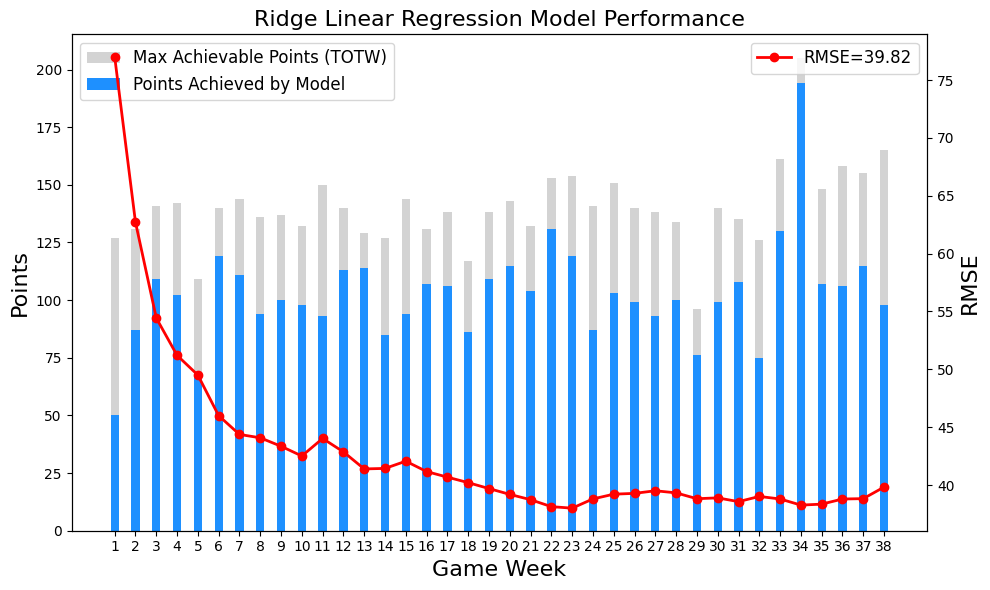

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Max achievable points (TOTW)
max_points = totw_points
indices = np.arange(1, len(max_points) + 1)
# Points achieved by the model
model_points = pred_points

# Plotting canvas
fig, ax1 = plt.subplots(figsize=(10, 6))
bar_width = 0.4

# Bars for max achievable points
bar1 = ax1.bar(
    indices,
    max_points,
    bar_width,
    label="Max Achievable Points (TOTW)",
    color="lightgray",
)

# Bars for model points achieved (overlapping)
bar2 = ax1.bar(
    indices,
    model_points,
    bar_width,
    label="Points Achieved by Model",
    color="dodgerblue",
)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
line = ax2.plot(indices, rmse, label=f"RMSE={round(mse,2)}", color="red", marker="o", linewidth=2)

# Labels, title, and legend
ax1.set_xlabel("Game Week", fontsize=16)
ax1.set_ylabel("Points", fontsize=16)
ax2.set_ylabel("RMSE", fontsize=16)
ax1.set_title("Ridge Linear Regression Model Performance", fontsize=16)
ax1.set_xticks(indices)
ax1.legend(loc="upper left", fontsize=12)
ax2.legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()

# 5. Comparison statistics

In [18]:
# Basic statistics

from numpy import mean, std

values = []
total_pts = []
xp_pts = []
st_dev_intra = []
for i in range(38):
    values.append(squads['players'][i]['value'].sum())
    total_pts.append(squads['players'][i]['total_points'].sum())
    xp_pts.append(squads['players'][i]['xP_inter'].sum())
    st_dev_intra.append(std(squads['players'][i]['total_points']))


print(f"rmse: {mse}, mae: {mae}, mape: {mape}")
print(f"values: {mean(values)}, total_pts: {mean(total_pts)}, exp_pts: {mean(xp_pts)}")
print(f"total_pts_std: {std(total_pts)}, exp_pts_std: {std(xp_pts)}, std_intra: {mean(st_dev_intra)}")

rmse: 39.82428510608227, mae: 37.5, mape: 0.2706311734688443
values: 726.3684210526316, total_pts: 102.71052631578948, exp_pts: 80.91578947368423
total_pts_std: 21.902785084546522, exp_pts_std: 16.807243524833183, std_intra: 4.727413586291961


In [30]:
# Overlap of players from the best team (TOTW)

df_totw = pd.read_pickle('data/df_totw.pkl')
df_players = pd.DataFrame(squads['players'][0])

for i in range(1,38):
    df_players = pd.concat([df_players, pd.DataFrame(squads['players'][i])])

overlap_pct = []
for i in range(1, 39):
    common_rows = df_totw[df_totw['GW'] == i].merge(df_players[df_players['GW'] == i], how='inner')
    overlap_pct.append(len(common_rows)/11)


mean(overlap_pct)

0.3397129186602871